In [4]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

# Download stopwords if you haven't already
nltk.download('stopwords')

# Load your data (replace 'Reviews.csv' with your actual file path)
data = pd.read_csv(r'C:\Users\masha\git\NEEC\Reviews.csv')

# Filter profiles and perform preprocessing as per your original process
profile_counts = data['ProfileName'].value_counts()
valid_profiles = profile_counts[profile_counts >= 100].index
filtered_df = data[data['ProfileName'].isin(valid_profiles)]

# Classify scores into positive/negative
def classify_score(score):
    if score < 3:
        return 0
    else:
        return 1

filtered_df['Score'] = filtered_df['Score'].map(classify_score)

# Removing duplicates
final = filtered_df.drop_duplicates(subset=["UserId", "ProfileName", "Time", "Text"], keep='first')

# Preprocess the text data
stop = set(stopwords.words('english'))  # Set of stopwords
sno = SnowballStemmer('english')  # Initialize Snowball Stemmer

# Function to clean HTML tags
def cleanhtml(sentence):
    cleanr = re.compile('<.*?>')
    return re.sub(cleanr, ' ', sentence)

# Function to remove punctuation
def cleanpunc(sentence):
    return re.sub(r'[?|!|\'|"|#]', r'', sentence)

# Preprocess the 'Text' column
final_string = []
list_of_sent = []

for sent in final['Text']:
    filtered_sentence = []
    sent = cleanhtml(sent)
    for w in sent.split():
        for cleaned_word in cleanpunc(w).split():
            if cleaned_word.isalpha() and len(cleaned_word) > 2:
                word_lower = cleaned_word.lower()
                if word_lower not in stop:
                    stemmed_word = sno.stem(word_lower)
                    filtered_sentence.append(stemmed_word)
    list_of_sent.append(filtered_sentence)
    final_string.append(" ".join(filtered_sentence))


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\masha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
C:\Users\masha\AppData\Local\Temp\ipykernel_23220\2571818153.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Score'] = filtered_df['Score'].map(classify_score)


In [5]:
# Add the cleaned text back into the DataFrame
final['CleanedText'] = final_string

C:\Users\masha\AppData\Local\Temp\ipykernel_23220\1703997883.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final['CleanedText'] = final_string


C:\Users\masha\AppData\Local\Temp\ipykernel_23220\686103690.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final['TokenizedText'] = final['CleanedText'].apply(lambda x: x.split())
C:\Users\masha\AppData\Local\Temp\ipykernel_23220\686103690.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final['ReviewEmbedding'] = final['TokenizedText'].apply(lambda tokens: get_review_embedding(tokens, word2vec_model))
C:\Users\masha\AppData\Local\Temp\ipykernel_23220\686103690.py:18: SettingWithCopyWarning: 
A val

Silhouette Score: 0.09


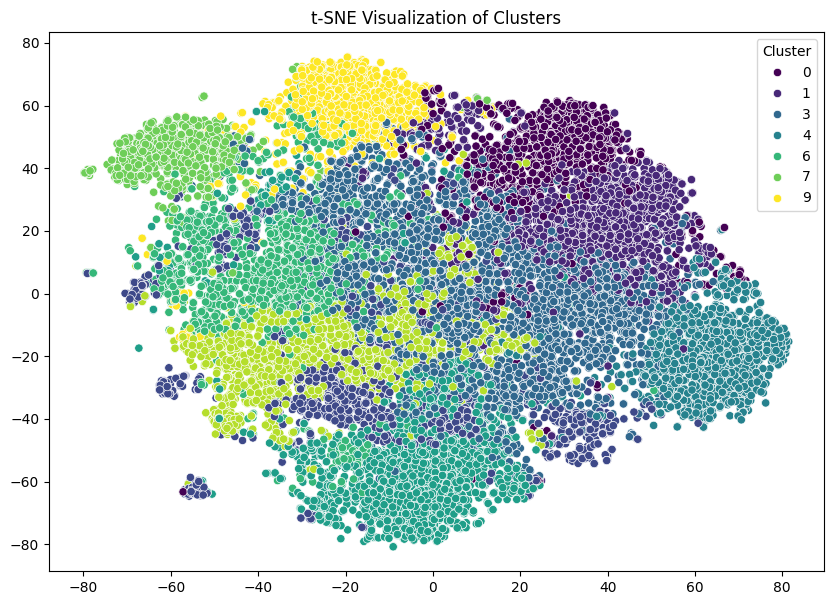


Cluster 0 sample reviews:
                                                  Text  Score
74   It is okay.  I would not go out of my way to b...      0
151  Works with chicken fish beef or pork. Fast eas...      1
431  Now, I haven't done a side-by-side comparison,...      1
555  Don't waste your money on any of the Kettle br...      0
668  Save a little money buying in larger quantitie...      1

Cluster 1 sample reviews:
                                                   Text  Score
14    The Strawberry Twizzlers are my guilty pleasur...      1
204   The tiny Altoids are great for a quick breath ...      1
385   The cashews were nice and big, with the vast m...      1
541   I've bought these at the local supermarket and...      0
1057  I was expecting to receive only Starburst. Whe...      1

Cluster 2 sample reviews:
                                                  Text  Score
466  I'm addicted to salty and tangy flavors, so wh...      1
467  These Honey Dijon chips bring a terrific

In [6]:

# Step 1: Tokenize cleaned text for Word2Vec training
final['TokenizedText'] = final['CleanedText'].apply(lambda x: x.split())

# Step 2: Train Word2Vec model on tokenized text
word2vec_model = Word2Vec(sentences=final['TokenizedText'], vector_size=100, window=5, min_count=2, workers=4)

# Step 3: Generate review embeddings by averaging word vectors
def get_review_embedding(tokens, model):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

final['ReviewEmbedding'] = final['TokenizedText'].apply(lambda tokens: get_review_embedding(tokens, word2vec_model))
review_embeddings = np.vstack(final['ReviewEmbedding'].values)

# Step 4: Cluster the review embeddings
num_clusters = 10
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
final['Cluster'] = kmeans.fit_predict(review_embeddings)

# Step 5: Evaluate clustering quality with silhouette score
silhouette_avg = silhouette_score(review_embeddings, final['Cluster'])
print(f'Silhouette Score: {silhouette_avg:.2f}')

# Step 6: Visualize clusters with t-SNE
tsne = TSNE(n_components=2, random_state=42)
review_embeddings_2d = tsne.fit_transform(review_embeddings)

plt.figure(figsize=(10, 7))
sns.scatterplot(x=review_embeddings_2d[:, 0], y=review_embeddings_2d[:, 1], hue=final['Cluster'], palette="viridis")
plt.title("t-SNE Visualization of Clusters")
plt.show()



In [8]:
from collections import Counter



Cluster 0 Summary:
Most common words: [('price', 505), ('store', 445), ('amazon', 417), ('buy', 408), ('find', 365), ('great', 334), ('local', 300), ('good', 281), ('product', 258), ('love', 254)]
Positive reviews: 1005, Negative reviews: 93
Sample reviews:
                                                  Text  Score
74   It is okay.  I would not go out of my way to b...      0
151  Works with chicken fish beef or pork. Fast eas...      1
431  Now, I haven't done a side-by-side comparison,...      1

Cluster 1 Summary:
Most common words: [('order', 798), ('product', 549), ('one', 455), ('box', 429), ('would', 412), ('bag', 340), ('love', 339), ('amazon', 327), ('great', 324), ('receiv', 318)]
Positive reviews: 1141, Negative reviews: 408
Sample reviews:
                                                  Text  Score
14   The Strawberry Twizzlers are my guilty pleasur...      1
204  The tiny Altoids are great for a quick breath ...      1
385  The cashews were nice and big, with the vas

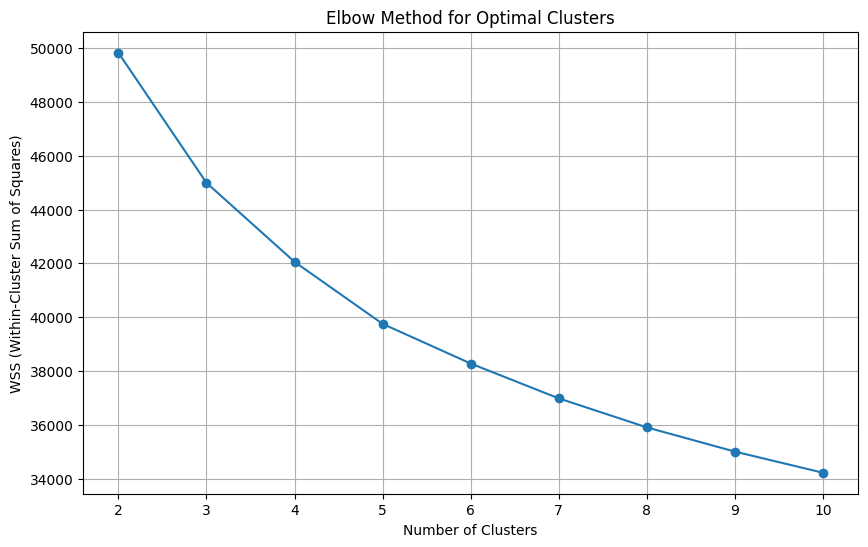

In [9]:
# Step 7: Analyze clusters
for cluster_num in range(num_clusters):
    print(f"\nCluster {cluster_num} Summary:")
    
    # Most common words in each cluster
    cluster_reviews = final[final['Cluster'] == cluster_num]
    cluster_words = " ".join(cluster_reviews['CleanedText'])
    word_counts = Counter(cluster_words.split())
    most_common_words = word_counts.most_common(10)
    print(f"Most common words: {most_common_words}")
    
    # Count positive and negative reviews
    pos_reviews = cluster_reviews[cluster_reviews['Score'] == 1].shape[0]
    neg_reviews = cluster_reviews[cluster_reviews['Score'] == 0].shape[0]
    print(f"Positive reviews: {pos_reviews}, Negative reviews: {neg_reviews}")
    
    # Sample a few reviews from each cluster for inspection
    print("Sample reviews:")
    print(cluster_reviews[['Text', 'Score']].head(3))  # Display top 3 sample reviews

# Step 8: Optional - Visualize WSS (Within-Cluster Sum of Squares) for Elbow Method
from scipy.cluster.hierarchy import fcluster
from sklearn.metrics import pairwise_distances_argmin_min

# Calculate WSS for different cluster sizes (if re-tuning the number of clusters)
wss_values = []
cluster_range = range(2, 11)

for k in cluster_range:
    kmeans_temp = KMeans(n_clusters=k, random_state=42)
    kmeans_temp.fit(review_embeddings)
    wss = kmeans_temp.inertia_
    wss_values.append(wss)

# Plot WSS to find the optimal number of clusters
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, wss_values, marker='o')
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('WSS (Within-Cluster Sum of Squares)')
plt.grid(True)
plt.show()